# Read in Data

In [26]:
import os
import pandas as pd
import numpy as np
import xgboost

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from pomegranate import NaiveBayes, NormalDistribution, BayesClassifier, BayesianNetwork, MultivariateGaussianDistribution

import scipy.sparse as sp

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer

import gensim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from frameworks.CPLELearning import CPLELearningModel

In [3]:
train_data = pd.read_csv("../input/train_v2.csv")
test_data = pd.read_csv("../input/test_v2.csv")

In [4]:
train_data.head(1)

,article_id,title,url,publisher,hostname,timestamp,category
0,1,Forex - Pound drops to one-month lows against ...,http://www.nasdaq.com/article/forex-pound-drop...,NASDAQ,www.nasdaq.com,1.390000e+12,4


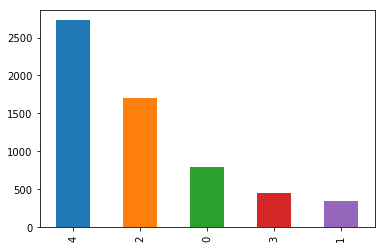

In [5]:
train_data.category.value_counts().plot('bar')

# Housekeeping

In [6]:
def stem(sent, stemmer_type='porter'):
    '''
    stemmer_type can be porter, lancaster, or snowball
    '''
    if stemmer_type == 'porter':
        stemmer = PorterStemmer()
    elif stemmer_type == 'lancaster':
        stemmer = LancasterStemmer()
    else:
        stemmer = SnowballStemmer('english')
    
    words = gensim.utils.simple_preprocess(sent)
    return ' '.join([stemmer.stem(word) for word in words])

In [7]:
def lemmatize(sent):
    lemmatizer = WordNetLemmatizer()
    
    words = gensim.utils.simple_preprocess(sent)
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

In [8]:
train_data["title"][1]

'Hertz to Exit Equipment Rental Business in $2.5B Spinoff'

In [9]:
train_data["title"].apply(stem)[1]

'hertz to exit equip rental busi in spinoff'

In [10]:
# perform stemming
train_data.loc[:, "title"] = train_data["title"].apply(stem)
test_data.loc[:, "title"] = test_data["title"].apply(stem)

In [11]:
# X_train, X_test, Y_train, Y_test = train_test_split(train_data["title"], train_data["category"], test_size = 0.2)
# X_train = np.array(X_train)
# X_test = np.array(X_test)  # indeed X_valid is a more accurate name
# Y_train = np.array(Y_train)
# Y_test = np.array(Y_test)  # indeed Y_valid is a more accurate name

In [12]:
def train_model(classifier, feature_vector_train, label_train, feature_vector_valid, label_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return {'accuracy': accuracy_score(label_valid, predictions), 
            # 'f2_seperate': fbeta_score(Y_test, Y_predict, average=None, beta=2),
            'f2_macro': fbeta_score(label_valid, predictions, average='macro', beta=2),
            'f2_micro': fbeta_score(label_valid, predictions, average='micro', beta=2),
            'f2_weighted': fbeta_score(label_valid, predictions, average='weighted', beta=2)}

In [13]:
def cross_validation_data(train_data):
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    for train_index, test_index in sss.split(train_data["title"], train_data["category"]):
        X_train, X_test = train_data["title"][train_index], train_data["title"][test_index]
        Y_train, Y_test = train_data["category"][train_index], train_data["category"][test_index]
        yield X_train, Y_train, X_test, Y_test

In [14]:
# # Not performing well
# def random_sample(X, y, method='RandomOverSampler'):
#     if method == 'RandomOverSampler':
#         sampler = RandomOverSampler()
#     elif method == 'RandomUnderSampler':
#         sampler = RandomUnderSampler()
#     elif method == 'ADASYN':
#         sampler = ADASYN()
#     elif method == 'SMOTE':
#         sampler = SMOTE()

#     return sampler.fit_sample(X, y)

In [15]:
# le_hostname = preprocessing.LabelEncoder()
# le_hostname.fit_transform(train_data['hostname']).shape

# le_publisher = preprocessing.LabelEncoder()
# le_publisher.fit_transform(train_data['publisher'].fillna('UNKNOWN'))

# Count Vectorizer

In [30]:
count_vect = CountVectorizer(analyzer='word',
                             ngram_range=(1,2),
                             # token_pattern=r'\w{1,}',
                             min_df=1,
                             max_features=4000)
count_vect.fit(train_data["title"].tolist() + test_data["title"].tolist())
# count_vect.fit(train_data["title"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=4000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [38]:
for clf_name, clf in [('LR', LogisticRegression()),
                      ('NB', MultinomialNB()),
                      ('XGB', xgboost.XGBClassifier(max_depth=5, n_estimators=140)),
                      ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy'))]:
    metrics_list = []
    for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data):
        xtrain_count =  count_vect.transform(X_train)
        xvalid_count =  count_vect.transform(X_test)
        if clf_name == 'XGB':
            metrics = train_model(clf, xtrain_count.tocsc(), Y_train, xvalid_count.tocsc(), Y_test)
        else:
            metrics = train_model(clf, xtrain_count, Y_train, xvalid_count, Y_test)
        metrics_list.append(metrics)
    print(clf_name, "mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
    print(clf_name, "mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
    print()

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR mean accuracy: 0.6427031509121062
LR mean f2_macro: 0.5571113588106928
LR mean f2_micro: 0.6427031509121062
LR mean f2_weighted: 0.6374668341887142

NB mean accuracy: 0.6372305140961857
NB mean f2_macro: 0.5792688637243283
NB mean f2_micro: 0.6372305140961857
NB mean f2_weighted: 0.635536090627901



KeyboardInterrupt: 

In [77]:
# clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
# accuracy = train_model(clf, xtrain_count, Y_train, xvalid_count, Y_test)

# Y_predict = clf.predict(xvalid_count)
# print(fbeta_score(Y_test, Y_predict, average=None, beta=1))
# print(fbeta_score(Y_test, Y_predict, average='macro', beta=1))
# print(fbeta_score(Y_test, Y_predict, average='weighted', beta=1))

# TF-IDF

In [20]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word',
                                   # token_pattern=r'\w{1,}', 
                                   ngram_range=(1,2), 
                                   max_df=1.0,
                                   min_df=1,
                                   max_features=4000)
tfidf_vect_ngram.fit(train_data["title"].tolist() + test_data["title"].tolist())
# tfidf_vect_ngram.fit(train_data["title"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=4000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [70]:
epochs = 1

In [64]:
for clf_name, clf in [
                      ('SVC', SVC(kernel='linear')),
                      ('LR', LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')),
                      ('NB', MultinomialNB()),
                      ('XGB', xgboost.XGBClassifier(max_depth=5, n_estimators=140)),
                      ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy'))
                     ]:
    metrics_list = []
    for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data):
        xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
        xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
        xsemi_tfidf_ngram = tfidf_vect_ngram.transform(np.concatenate([X_train, X_test, test_data["title"]]))
        
        # First training using only training set
        if clf_name == 'XGB':
            _ = train_model(clf, xtrain_tfidf_ngram.tocsc(), Y_train, xvalid_tfidf_ngram.tocsc(), Y_test)
        else:
            _ = train_model(clf, xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
            
        # semi supervised stage
        for epoch in range(epochs):
            # create labels
            ysemi = clf.predict(xsemi_tfidf_ngram.tocsc()) if clf_name == 'XGB' else clf.predict(xsemi_tfidf_ngram)
            ysemi[:len(Y_train)] = Y_train  # Use ground truth for training set
        
            metrics = train_model(clf, xsemi_tfidf_ngram.tocsc(), ysemi, xvalid_tfidf_ngram.tocsc(), Y_test) \
                if clf_name == 'XGB' else train_model(clf, xsemi_tfidf_ngram, ysemi, xvalid_tfidf_ngram, Y_test)
        metrics_list.append(metrics)

    print(clf_name, "mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
    print(clf_name, "mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
    print()

SVC mean accuracy: 0.6639303482587064
SVC mean f2_macro: 0.5579906057393922
SVC mean f2_micro: 0.6639303482587064
SVC mean f2_weighted: 0.654221240092429

LR mean accuracy: 0.6571310116086236
LR mean f2_macro: 0.5456197204260589
LR mean f2_micro: 0.6571310116086236
LR mean f2_weighted: 0.6474431982246183

NB mean accuracy: 0.6539800995024876
NB mean f2_macro: 0.5202492034650905
NB mean f2_micro: 0.6539800995024876
NB mean f2_weighted: 0.640543830328168



KeyboardInterrupt: 

In [ ]:
# epoch=1, ground_truth
# SVC ~0.66

# epoch=1, no_ground_truth
# SVC 0.6635

# epoch=2, no_ground_truth
# SVC 0.6643

# epoch=2, ground_truth
# SVC 0.6639

In [85]:
# Use only high confident data as extra training data

metrics_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data):
#     clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
    clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
#     clf = xgboost.XGBClassifier(max_depth=5, n_estimators=140)
    
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    xsemi_tfidf_ngram = tfidf_vect_ngram.transform(np.concatenate([X_test, test_data["title"]]))

    # First training using only training set
    _ = train_model(clf, xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)

    # semi supervised stage
    for epoch in range(epochs):
        # create labels
        prob_semi = clf.predict_proba(xsemi_tfidf_ngram)
        THRESHOLD = 0.6
        mask = np.amax(prob_semi, axis=1) > THRESHOLD

        ysemi = clf.predict(xsemi_tfidf_ngram)

        print(ysemi[mask].shape)

        if epoch == epochs-1:
            # Use SVC for last epoch
            metrics = train_model(SVC(kernel='linear'),
                                  sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                                  np.concatenate((Y_train, ysemi[mask])), 
                                  xvalid_tfidf_ngram, Y_test)
#             metrics = train_model(xgboost.XGBClassifier(max_depth=5, n_estimators=140),
#                               sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
#                               np.concatenate((Y_train, ysemi[mask])), 
#                               xvalid_tfidf_ngram, Y_test)
        else:
            metrics = train_model(clf,
                                  sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                                  np.concatenate((Y_train, ysemi[mask])), 
                                  xvalid_tfidf_ngram, Y_test)
    metrics_list.append(metrics)

print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

(3545,)
(3510,)
(3523,)
(3569,)
(3480,)
(3540,)
(3465,)
(3436,)
(3474,)
(3513,)
mean accuracy: 0.6659203980099503
mean f2_macro: 0.5654517180966205
mean f2_micro: 0.6659203980099503
mean f2_weighted: 0.6564738412399914



In [ ]:
threshold 0.6

xgb + svc
0.6653

rf + svc
0.6659

In [ ]:
# SVM

# epoch 2
# threshold 0.7
# 0.6637

# threshold 0.6
# 0.6623

# threshold 0.5
# 0.6591

# eopch 1
# threshold 0.7
# 0.6641

# threshold 0.6
# 0.6637

# threshold 0.55
# 0.6622

In [ ]:
# XGB

# epoch 1
# threshold 0.6
# 0.6509

In [86]:
# CREATE SUBMISSION

# Use only high confident data as extra training data
metrics_list = []

# clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
clf = RandomForestClassifier(n_estimators=180, criterion='entropy')

train_tfidf_ngram =  tfidf_vect_ngram.transform(train_data["title"])
xsemi_tfidf_ngram = tfidf_vect_ngram.transform(test_data["title"])

# First training using only training set
_ = train_model(clf, train_tfidf_ngram, train_data["category"], train_tfidf_ngram, train_data["category"])

# semi supervised stage
for epoch in range(epochs):
    # create labels
    prob_semi = clf.predict_proba(xsemi_tfidf_ngram)
    THRESHOLD = 0.6
    mask = np.amax(prob_semi, axis=1) > THRESHOLD

    ysemi = clf.predict(xsemi_tfidf_ngram)

    print(ysemi[mask].shape)

    if epoch == epochs-1:
        # Use SVC for last epoch
        final_clf = SVC(kernel='linear')
        metrics = train_model(final_clf,
                          sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                          np.concatenate((train_data["category"], ysemi[mask])), 
                          train_tfidf_ngram, train_data["category"])
    else:
        metrics = train_model(clf,
                          sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                          np.concatenate((train_data["category"], ysemi[mask])), 
                          train_tfidf_ngram, train_data["category"])
metrics_list.append(metrics)

print("On training set: ")
print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

(2817,)
On training set: 
mean accuracy: 0.7527791604446656
mean f2_macro: 0.6410412422457743
mean f2_micro: 0.7527791604446656
mean f2_weighted: 0.7449502313641395



In [87]:
test_data["category"] = final_clf.predict(tfidf_vect_ngram.transform(test_data["title"]))

out=pd.DataFrame(test_data,columns=['article_id','category'])
out.to_csv('prediction.csv',index=False)

In [ ]:
# xtrain_tfidf_resampled, Y_train_resampled = random_sample(xtrain_tfidf_ngram, Y_train, method='ADASYN')

# # Extereme Gradient Boosting on Word Level TF IDF Vectors
# accuracy = train_model(xgboost.XGBClassifier(max_depth=5, n_estimators=140), xtrain_tfidf_resampled.tocsc(), Y_train_resampled, xvalid_tfidf_ngram.tocsc(), Y_test)
# print("Xgb, WordLevel TF-IDF: ", accuracy)

In [ ]:
# clf = xgboost.XGBClassifier(max_depth=5, n_estimators=140)
# accuracy = train_model(clf, xtrain_tfidf_resampled.tocsc(), Y_train_resampled, xvalid_tfidf_ngram.tocsc(), Y_test)

# Y_predict = clf.predict(xvalid_tfidf_ngram.tocsc())
# print(fbeta_score(Y_test, Y_predict, average=None, beta=1))

# Other Semi-supervised Methods

In [15]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word',
                                   # token_pattern=r'\w{1,}', 
                                   ngram_range=(1,2), 
                                   max_df=1.0,
                                   min_df=1,
                                   max_features=4000)
tfidf_vect_ngram.fit(train_data["title"].tolist() + test_data["title"].tolist())
# tfidf_vect_ngram.fit(train_data["title"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=4000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

# CPLE

NOT WORKING YET. Looks like this is only suitable for binary classification

In [26]:
import sys, importlib
importlib.reload(sys.modules['frameworks.CPLELearning'])
from frameworks.CPLELearning import CPLELearningModel

In [27]:
test_data.loc[:, "category"] = -1
xsemi_tfidf_ngram = tfidf_vect_ngram.transform(test_data["title"])
ysemi = test_data["category"]

metrics_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data):
    clf = CPLELearningModel(LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr'))
#     clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
#     clf = xgboost.XGBClassifier(max_depth=5, n_estimators=140)
#     clf = CPLELearningModel(SVC(kernel="linear", probability=True), predict_from_probabilities=True)
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    
    metrics = train_model(clf,
                          sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram)).toarray(), 
                          np.concatenate((Y_train, ysemi)), 
                          xvalid_tfidf_ngram.toarray(), 
                          Y_test)

    metrics_list.append(metrics)
    print(metrics['accuracy'])

print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

start training on labeled data
re-train, labeling unlabeled instances pessimistically
(3826, 2) (3826, 5) (3826,)
132 operands could not be broadcast together with shapes (3826,2) (3826,5) 
local variable 'unlabeledDL' referenced before assignment
calculating likelihood


TypeError: unsupported operand type(s) for -: 'int' and 'list'

# QN-S3VM

In [32]:
from methods.scikitTSVM import SKTSVM

In [33]:
# import sys, importlib
# importlib.reload(sys.modules['methods.scikitTSVM'])
# from methods.scikitTSVM import SKTSVM

In [34]:
import warnings
warnings.filterwarnings("ignore", category=PendingDeprecationWarning)

In [35]:
test_data.loc[:, "category"] = -1
xsemi_tfidf_ngram = tfidf_vect_ngram.transform(test_data["title"])
ysemi = test_data["category"]

metrics_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data):
    clf = SKTSVM(kernel='linear')
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    
    metrics = train_model(clf,
                          sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram)).toarray(), 
                          np.concatenate((Y_train, ysemi)), 
                          xvalid_tfidf_ngram.toarray(), 
                          Y_test)

    metrics_list.append(metrics)
    print(metrics['accuracy'])

print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

SystemError: <built-in function isinstance> returned a result with an error set

# EM

In [29]:
from sklearn.naive_bayes import GaussianNB

In [31]:
test_data.loc[:, "category"] = -1
xsemi_tfidf_ngram = tfidf_vect_ngram.transform(test_data["title"])
ysemi = test_data["category"]

metrics_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data):
    
    
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    
    clf = BayesClassifier.from_samples(MultivariateGaussianDistribution,
                                  #sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram)).toarray(),
                                  #np.concatenate((Y_train, ysemi)),
                                  xtrain_tfidf_ngram.toarray(),
                                  Y_train)
#     clf = NaiveBayes.from_samples(NormalDistribution,
#                               #sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram)).toarray(),
#                               #np.concatenate((Y_train, ysemi)),
#                               xtrain_tfidf_ngram.toarray(),
#                               Y_train)

#     clf = GaussianNB()
#     clf.fit(xtrain_tfidf_ngram.toarray(), Y_train)
    
    predictions = clf.predict(xvalid_tfidf_ngram.toarray())
    
    metrics = {'accuracy': accuracy_score(Y_test, predictions), 
               # 'f2_seperate': fbeta_score(Y_test, Y_predict, average=None, beta=2),
               'f2_macro': fbeta_score(Y_test, predictions, average='macro', beta=2),
               'f2_micro': fbeta_score(Y_test, predictions, average='micro', beta=2),
               'f2_weighted': fbeta_score(Y_test, predictions, average='weighted', beta=2)}

    metrics_list.append(metrics)
    print(metrics['accuracy'])

print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

# Try Voting

In [117]:
def fuse_results(predictions_list, xgb_offset=1):
    final_predictions = []
    percentage = 0
    for preds in zip(*predictions_list):
        sr_count = pd.Series(preds).value_counts()
        if sr_count.iloc[0] >= 2 and sr_count.index[0] != preds[1]:
            final_predictions.append(sr_count.index[0])  # the most commonly predicted class
            percentage +=1
        else:
            final_predictions.append(preds[1])  # use result of xgb
    
    print(percentage)
    return final_predictions

In [142]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word',
                                   # token_pattern=r'\w{1,}', 
                                   ngram_range=(1,2), 
                                   max_df=1.0,
                                   min_df=2,
                                   max_features=4000)
tfidf_vect_ngram.fit(train_data["title"].tolist() + test_data["title"].tolist())
# tfidf_vect_ngram.fit(train_data["title"])


acc_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data):
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    
    predictions_list = []
    for clf_name, clf in [
                          ('KNN', KNeighborsClassifier(n_neighbors=40, weights='distance')),
#                           ('LR', LogisticRegression()),
#                           ('LR', LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')),
                          ('NB', MultinomialNB(alpha=0.5, fit_prior=True)),
#                           ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy')),
                          ('XGB', xgboost.XGBClassifier(max_depth=5, n_estimators=140)),
#                           ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy'))
                         ]:
        if clf_name == 'XGB':
            clf.fit(xtrain_tfidf_ngram.tocsc(), Y_train)
            predictions = clf.predict(xvalid_tfidf_ngram.tocsc())
        else:
            clf.fit(xtrain_tfidf_ngram, Y_train)
            predictions = clf.predict(xvalid_tfidf_ngram)
    
        predictions_list.append(predictions)
    
    final_predictions = fuse_results(predictions_list)
    accuracy = accuracy_score(Y_test, final_predictions)
    print(accuracy)
    acc_list.append(accuracy)

print(sum(acc_list)/len(acc_list))

41
0.6575456053067993
43
0.6558872305140961
56
0.6716417910447762
56
0.6658374792703151
58
0.6749585406301825
50
0.664179104477612
59
0.6650082918739635
51
0.6890547263681592
56
0.693200663349917
72
0.6509121061359867
0.6688225538971808


In [ ]:
# lr, rf, xgb
# 0.6624378109452737

# lr_ovr, nb, xgb
# 0.6604477611940299

# knn, lr, xgb
# 0.6640132669983416

# knn, nb, xgb
# 0.6688225538971808

# knn, rf, xgb
# 0.6671641791044776

# nb, rf, xgb
# 0.6629353233830845

In [145]:
# create submission
train_tfidf_ngram =  tfidf_vect_ngram.transform(train_data["title"])
test_tfidf_ngram =  tfidf_vect_ngram.transform(test_data["title"])

    
predictions_list = []
for clf_name, clf in [
                      ('KNN', KNeighborsClassifier(n_neighbors=40, weights='distance')),
#                       ('LR', LogisticRegression()),
#                       ('LR', LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')),
                      ('NB', MultinomialNB(alpha=0.5, fit_prior=True)),
#                       ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy')),
                      ('XGB', xgboost.XGBClassifier(max_depth=5, n_estimators=140)),
#                       ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy'))
                     ]:
    if clf_name == 'XGB':
        clf.fit(train_tfidf_ngram.tocsc(), train_data["category"])
        predictions = clf.predict(test_tfidf_ngram.tocsc())
    else:
        clf.fit(train_tfidf_ngram, train_data["category"])
        predictions = clf.predict(test_tfidf_ngram)

    predictions_list.append(predictions)

final_predictions = fuse_results(predictions_list)

test_data["category"] = final_predictions

out=pd.DataFrame(test_data,columns=['article_id','category'])
out.to_csv('prediction.csv',index=False)

137


# Create Submission

In [77]:
train_tfidf_ngram =  tfidf_vect_ngram.transform(train_data["title"])
test_tfidf_ngram =  tfidf_vect_ngram.transform(test_data["title"])

In [26]:
classifier = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140)
metrics = train_model(classifier, train_tfidf_ngram.tocsc(), train_data["category"], train_tfidf_ngram.tocsc(), train_data["category"])
print("XGB on training set ", metrics)

test_data["category"] = classifier.predict(test_tfidf_ngram.tocsc())

XGB on training set  0.7375145180023229


In [78]:
classifier = KNeighborsClassifier(n_neighbors=40, weights='distance')
metrics = train_model(classifier, train_tfidf_ngram, train_data["category"], train_tfidf_ngram, train_data["category"])
print("XGB on training set ", metrics)

XGB on training set  {'accuracy': 0.9905425584868094, 'f2_macro': 0.9906536277966065, 'f2_micro': 0.9905425584868094, 'f2_weighted': 0.9905380591051429}


In [27]:
# classifier = RandomForestClassifier(n_estimators=180, criterion='entropy')
# metrics = train_model(classifier, train_tfidf_ngram, train_data["category"], train_tfidf_ngram, train_data["category"])
# print("RF on training set ", metrics)

# test_data["category"] = classifier.predict(test_tfidf_ngram)

In [79]:
test_data["category"] = classifier.predict(test_tfidf_ngram)

out=pd.DataFrame(test_data,columns=['article_id','category'])
out.to_csv('prediction.csv',index=False)